# Importancia de cada columna del set original

## Constantes globales 

In [2]:
TARGET = 'precio'

## Imports 

#### Import pandas, numpy and & plots 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#### Import sklearn

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor # precio es variable continua
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

#### Import common 

In [5]:
import common.common_machine_learning as common

## Carga optimizada del set de datos 

In [6]:
train = common.cargar_set_optimizado('sets_de_datos/train.csv')

### Trabajaremos con una muestra para mejorar performance 

In [15]:
muestra_25 = train.sample(frac = 0.25, random_state = 1)

## Funciones y metodos de scoring

Mediremos cuanto depende el target : precio, de cada columna del set original: train.csv  

Funcion de scoring: 

- f_classif (ANOVA F-value)
- chi2 (X^2), 
- mutual information score.

Todas las anteriores son 'Univariate Feature Selectors'.
Puede utilizarze SelectKBest para seleccionar las K mejores features, a partir de alguna de las funciones anteriores.

Otros metodos de scoring.

- L1 regularization (Lasso Regression)
- Random Forest


Estos metodos necesitan del que los features tomen valores numericos, por lo que tendremos que transformar el set de datos mediante algun encoding:

- One Hot Encoding (Problema : puede generar muchos features)
- Label Encoding (Problema : variables numericas dan sensacion de orden)

In [16]:
muestra_25.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 132827 to 83779
Data columns (total 23 columns):
id                            60000 non-null int32
titulo                        58647 non-null object
descripcion                   59579 non-null object
tipodepropiedad               59993 non-null object
direccion                     46642 non-null object
ciudad                        59912 non-null object
provincia                     59958 non-null object
antiguedad                    49120 non-null float16
habitaciones                  54381 non-null float16
garages                       50564 non-null float16
banos                         53502 non-null float16
metroscubiertos               55672 non-null float16
metrostotales                 47273 non-null float16
idzona                        52912 non-null float32
lat                           29266 non-null float64
lng                           29266 non-null float64
fecha                         60000 non-null d

Vamos a descartar para este primer analisis las columnas de titulo, descripcion, direccion, lat, lng, fecha, idzona, que generan muchisimas sub-categorias

In [17]:
# Droppeamos strings y columnas complejas y repetidas
drop_cols = ['titulo', 'descripcion', 'direccion', 'lat', 'lng', 'fecha', 'idzona']
muestra_25 = muestra_25.drop(drop_cols, axis=1).copy()
muestra_25.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 132827 to 83779
Data columns (total 16 columns):
id                            60000 non-null int32
tipodepropiedad               59993 non-null object
ciudad                        59912 non-null object
provincia                     59958 non-null object
antiguedad                    49120 non-null float16
habitaciones                  54381 non-null float16
garages                       50564 non-null float16
banos                         53502 non-null float16
metroscubiertos               55672 non-null float16
metrostotales                 47273 non-null float16
gimnasio                      60000 non-null bool
usosmultiples                 60000 non-null bool
piscina                       60000 non-null bool
escuelascercanas              60000 non-null bool
centroscomercialescercanos    60000 non-null bool
precio                        60000 non-null float32
dtypes: bool(5), float16(6), float32(1), int32(1), object(

In [19]:
print('Cantidad de categorias en tiposdepropiedad : ' + str(muestra_25['tipodepropiedad'].value_counts().count()))
print('Cantidad de categorias en provincia : ' + str(muestra_25['provincia'].value_counts().count()))
print('Cantidad de categorias en ciudad : ' + str(muestra_25['ciudad'].value_counts().count()))

Cantidad de categorias en tiposdepropiedad : 22
Cantidad de categorias en provincia : 32
Cantidad de categorias en ciudad : 566


Aproximandamente tenemos 600 categorias que codificar.  
Si usamos One Hot Encoding, entonces estariamos agregando 600 columnas a nuestro set de datos. si bien dependiendo de la  computadora podria bancarselo o no, el resultado no seria que lo que se quisiese analizar.  
Por lo tanto, si bien el modelo podria predecir mal, vamos a utilizar Label Encoding.

In [22]:
cat_features = ['tipodepropiedad', 'provincia', 'ciudad']

label_encoder = LabelEncoder()

for cat in cat_features:
    muestra_25 = muestra_25.fillna(value = {cat : 'NaN'})
    muestra_25[cat] = label_encoder.fit_transform(muestra_25[cat])    

In [23]:
muestra_25.head()

,id,tipodepropiedad,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
132827,245130,3,332,21,10.0,3.0,2.0,2.0,172.0,110.0,False,False,False,True,True,2300000.0
210008,179086,0,61,8,NaN,2.0,1.0,2.0,76.0,76.0,True,True,True,True,True,2262945.0
189056,87774,2,140,8,17.0,5.0,0.0,NaN,245.0,170.0,False,False,False,False,False,3800000.0
131466,260997,2,184,14,20.0,3.0,0.0,1.0,185.0,145.0,False,False,False,False,False,1000000.0
207302,109591,2,35,19,NaN,2.0,1.0,1.0,40.0,90.0,False,False,False,False,False,376200.0


In [33]:
feature_cols = muestra_25.columns.drop(TARGET)
muestra_25_porciento = train_simple.sample(frac = 0.25, random_state = 1)
muestra_25_X = muestra_25.drop([TARGET], axis=1)
muestra_25_y = muestra_25[TARGET]

### Imputar nulls numericos 

In [34]:
cols_con_null_a_cero = ['habitaciones', 'banos', 'garages']
cols_con_null_a_promedio = ['metrostotales', 'metroscubiertos', 'antiguedad']

In [36]:
imp_mean = SimpleImputer()
for col in cols_con_null_a_promedio:
    muestra_25_X[col] = imp_mean.fit_transform(muestra_25_X[[col]])  

In [37]:
for col in cols_con_null_a_cero:
    muestra_25_X[col] = muestra_25_X.fillna(value = {col : 0})  

### f_classif

In [41]:
selector = SelectKBest(f_classif, k=3)

muestra_25_X_new = selector.fit_transform(muestra_25_X, muestra_25_y)
muestra_25_X_new

array([[3, 172.0, 110.0],
       [0, 76.0, 76.0],
       [2, 245.0, 170.0],
       ...,
       [3, 173.57775901710016, 236.0],
       [2, 89.0, 34.0],
       [2, 120.0, 176.31362511370128]], dtype=object)

In [42]:
feature_cols

Index(['id', 'tipodepropiedad', 'ciudad', 'provincia', 'antiguedad',
       'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos'],
      dtype='object')

In [43]:
selector.scores_

array([0.97788589, 2.44158079, 1.20816121, 1.40583951, 0.86116748,
       0.97788589, 0.97788589, 0.97788589, 9.35188493, 4.61121211,
       1.63268287, 1.55937629, 1.35914493, 0.99417617, 0.97673635])

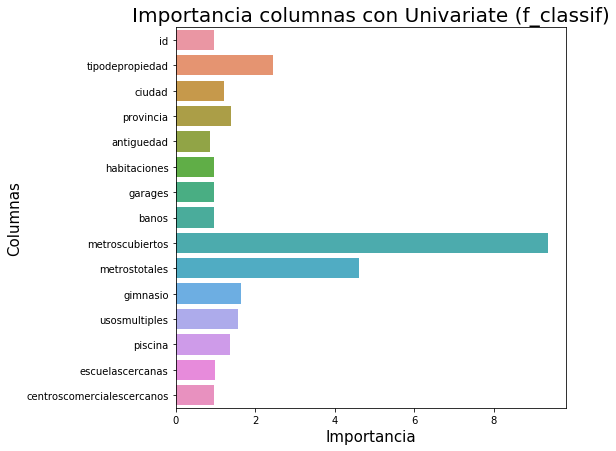

In [44]:
plot = sns.barplot(
            x = selector.scores_,
            y = feature_cols
        )

plot.set_xlabel('Importancia', fontsize = 15)
plot.set_ylabel('Columnas', fontsize = 15)
plot.set_title('Importancia columnas con Univariate (f_classif)', fontsize = 20)
fig = plot.get_figure()
fig.set_size_inches(7,7)

#plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
plt.show()

In [46]:
selected_features = pd.DataFrame(selector.inverse_transform(muestra_25_X_new), 
                                 index=muestra_25_X.index, 
                                 columns=feature_cols)
selected_features.head()

,id,tipodepropiedad,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos
132827,0,3,0,0,0,0,0,0,172,110,0,0,0,0,0
210008,0,0,0,0,0,0,0,0,76,76,0,0,0,0,0
189056,0,2,0,0,0,0,0,0,245,170,0,0,0,0,0
131466,0,2,0,0,0,0,0,0,185,145,0,0,0,0,0
207302,0,2,0,0,0,0,0,0,40,90,0,0,0,0,0


In [47]:
selected_columns = selected_features.columns[selected_features.var() != 0]

In [48]:
selected_columns

Index(['tipodepropiedad', 'metroscubiertos', 'metrostotales'], dtype='object')

In [49]:
#train_simple_X_test[selected_columns].head()

### chi2

In [50]:
selector_chi2 = SelectKBest(chi2, k=3)

muestra_25_X_new = selector_chi2.fit_transform(muestra_25_X, muestra_25_y)

In [51]:
selector_chi2.scores_

array([2.90077157e+08, 8.36612651e+04, 6.62771016e+05, 3.14167371e+04,
       4.83547075e+04, 2.90077157e+08, 2.90077157e+08, 2.90077157e+08,
       1.56167272e+06, 7.97492271e+05, 8.54643955e+03, 8.28670285e+03,
       7.10054521e+03, 3.27246964e+03, 3.49957177e+03])

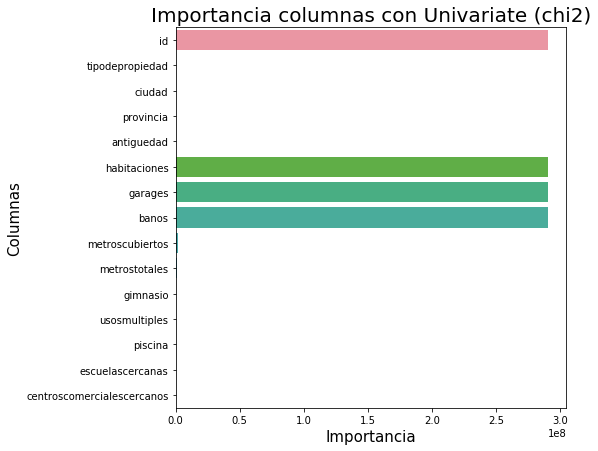

In [52]:
plot = sns.barplot(
            y = feature_cols,
            x = selector_chi2.scores_,
        )

plot.set_xlabel('Importancia', fontsize = 15)
plot.set_ylabel('Columnas', fontsize = 15)
plot.set_title('Importancia columnas con Univariate (chi2)', fontsize = 20)
fig = plot.get_figure()
fig.set_size_inches(7,7)

plt.show()

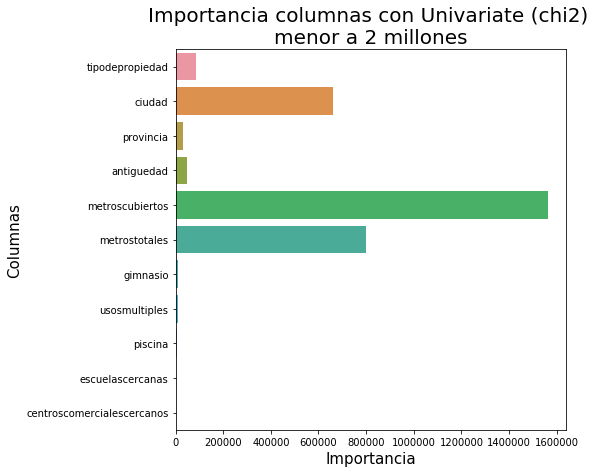

In [70]:
plot = sns.barplot(
            x = np.append(selector_chi2.scores_[1:5], selector_chi2.scores_[8:]),
            y = np.append(feature_cols[1:5], feature_cols[8:])
        )

plot.set_xlabel('Importancia', fontsize = 15)
plot.set_ylabel('Columnas', fontsize = 15)
plot.set_title('Importancia columnas con Univariate (chi2) \nmenor a 2 millones', fontsize = 20)
fig = plot.get_figure()
fig.set_size_inches(7,7)

plt.show()

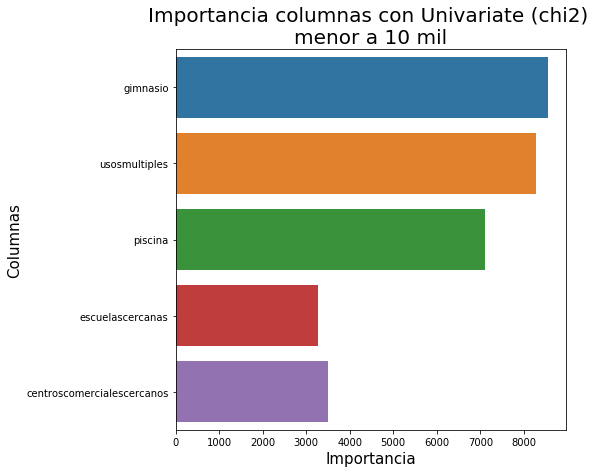

In [69]:
plot = sns.barplot(
            x = selector_chi2.scores_[10:],
            y = feature_cols[10:]
        )

plot.set_xlabel('Importancia', fontsize = 15)
plot.set_ylabel('Columnas', fontsize = 15)
plot.set_title('Importancia columnas con Univariate (chi2) \nmenor a 10 mil', fontsize = 20)
fig = plot.get_figure()
fig.set_size_inches(7,7)

plt.show()

### mutual_info_classif

In [64]:
selector_mutual = SelectKBest(mutual_info_classif, k=3)

muestra_25_X_new = selector_mutual.fit_transform(muestra_25_X, muestra_25_y)

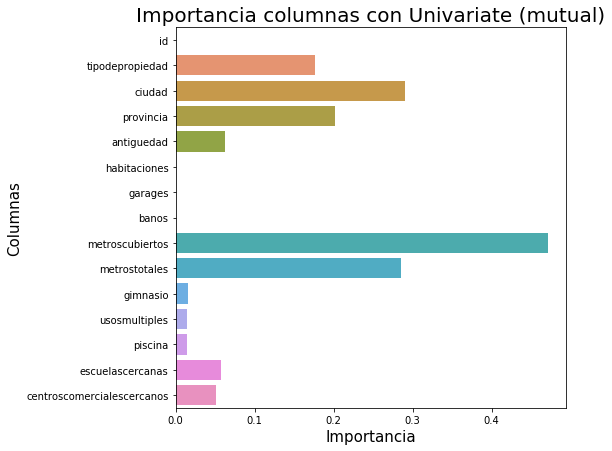

In [65]:
plot = sns.barplot(
            y = feature_cols,
            x = selector_mutual.scores_,
        )

plot.set_xlabel('Importancia', fontsize = 15)
plot.set_ylabel('Columnas', fontsize = 15)
plot.set_title('Importancia columnas con Univariate (mutual)', fontsize = 20)
fig = plot.get_figure()
fig.set_size_inches(7,7)

plt.show()

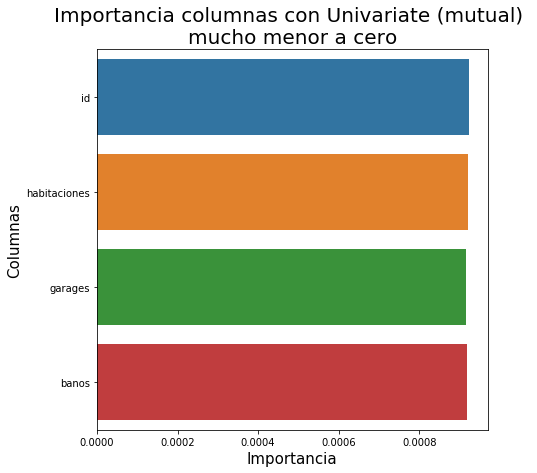

In [68]:
plot = sns.barplot(
            x = np.append(selector_mutual.scores_[0], selector_mutual.scores_[5:8]) ,
            y = np.append(feature_cols[0], feature_cols[5:8])
        )

plot.set_xlabel('Importancia', fontsize = 15)
plot.set_ylabel('Columnas', fontsize = 15)
plot.set_title('Importancia columnas con Univariate (mutual) \nmucho menor a cero', fontsize = 20)
fig = plot.get_figure()
fig.set_size_inches(7,7)

plt.show()

## L1 regularization (Lasso Regression)

Penalización al aumentar la complejidad del modelo

In [ ]:
# Set the regularization parameter C=1
logistic = LogisticRegression(C=1, penalty="l1", random_state=7, solver = 'lbfgs', multi_class = 'auto').fit(muestra_25_X, muestra_25_y)

In [ ]:
logistic.coef_

In [ ]:
plt.bar(feature_cols, logistic.coef_[0])
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Lasso')
plt.show()

In [ ]:
model = SelectFromModel(logistic, prefit=True, max_features=3)

X_new = model.transform(X)

In [ ]:
selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=train.index, 
                                 columns=feature_cols)
selected_features.head()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

X, y = train[train.columns.drop("outcome")], train['outcome']
val_X, val_y = valid[valid.columns.drop("outcome")], valid['outcome']

forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(X, y)
preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, preds))

In [ ]:
forest_model.feature_importances_

In [ ]:
plt.bar(feature_cols, forest_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

In [ ]:
model = SelectFromModel(forest_model, prefit=True, max_features=3)

X_new = model.transform(X)

In [ ]:
X_new